<a href="https://colab.research.google.com/github/piziomo/Generative-AI-Trainings/blob/main/GANs/Simple%20GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 4: Introduction to Generative Adversarial Networks (GANs)

## Introduction: What is a GAN and how does it work?

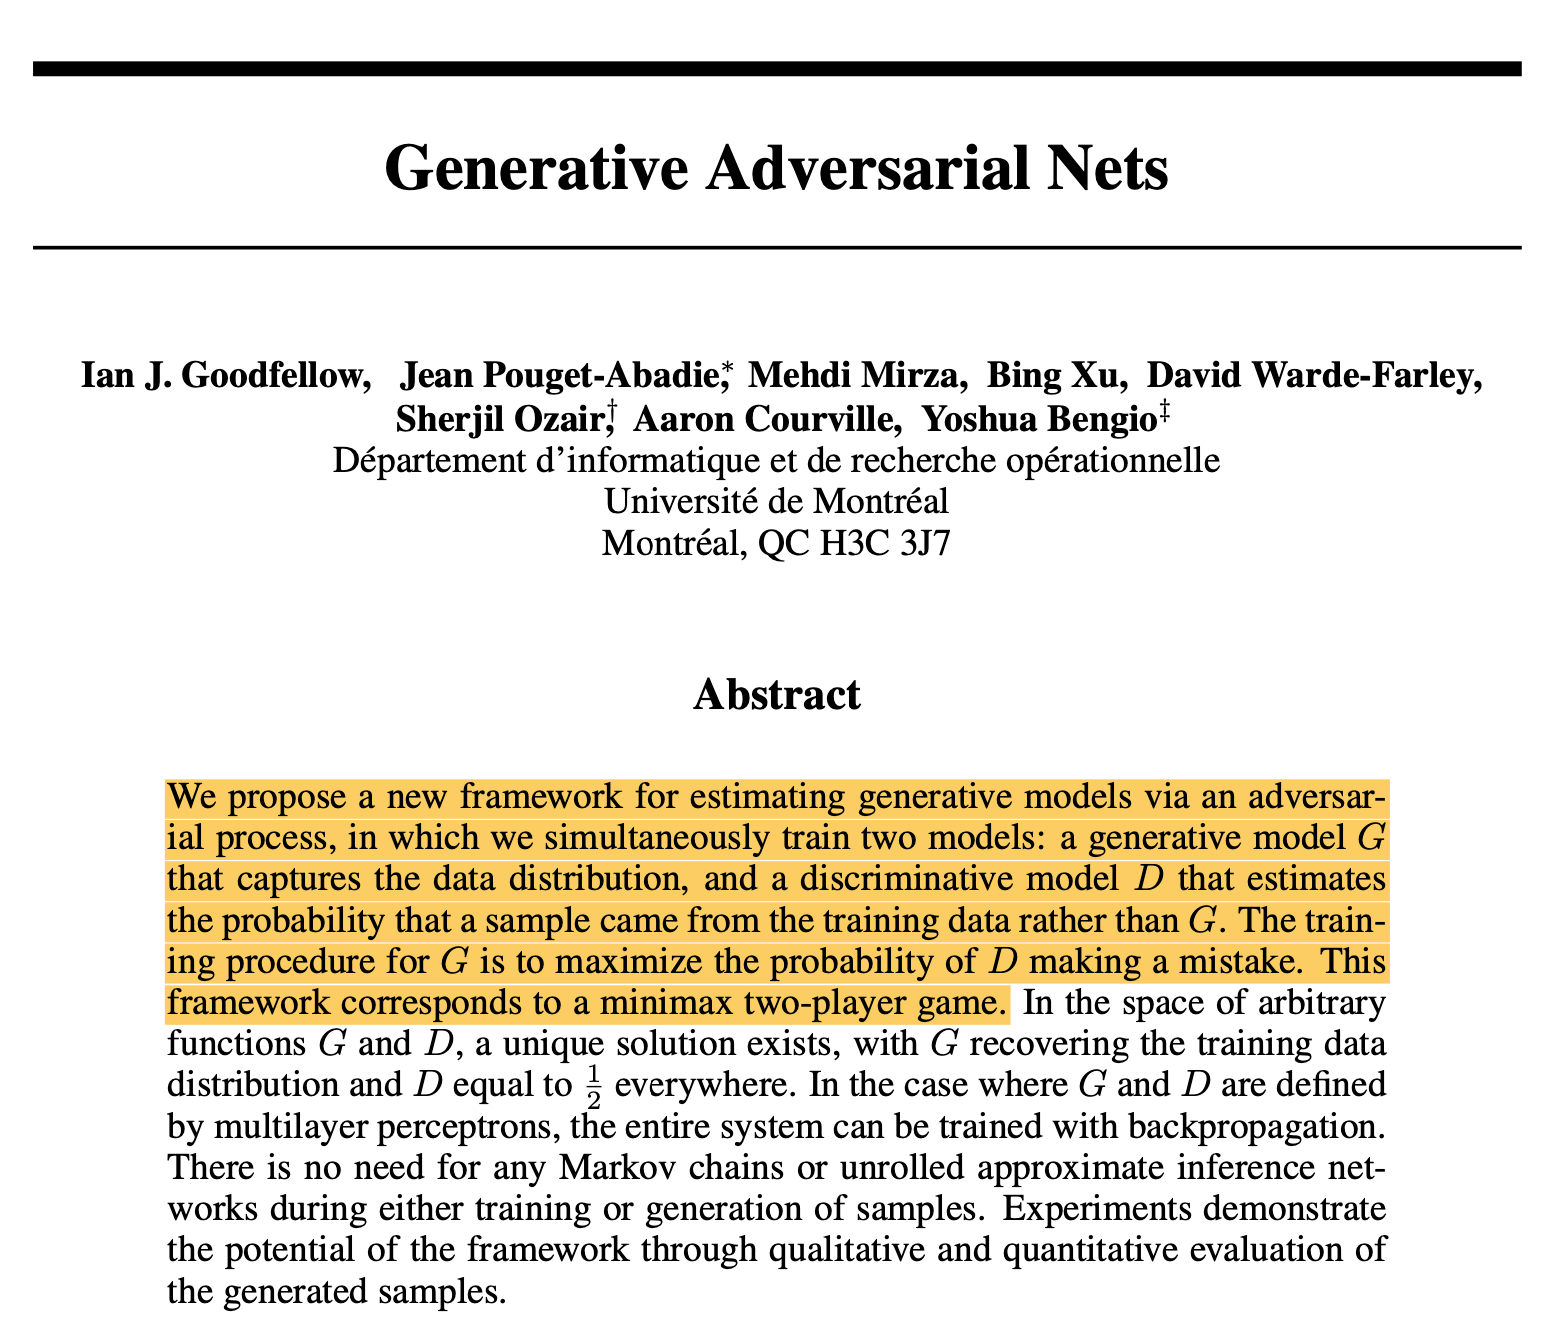

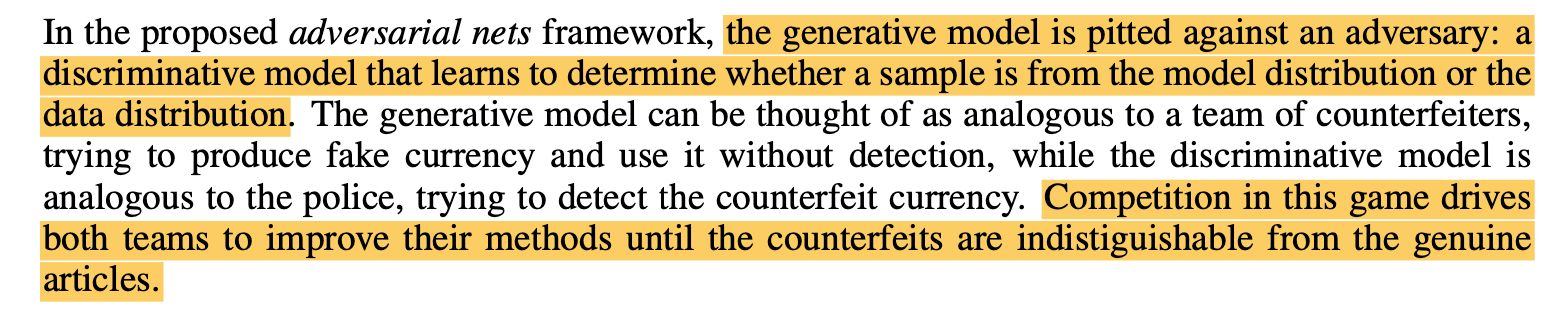

To put it simply, GANs are based on the idea of two neural networks competing against each other (hence, why it is called a generative *adversarial* network).

To explain GANs, the analogy of forging currency (or paintings, etc.) is foten used to explain how GANs work.

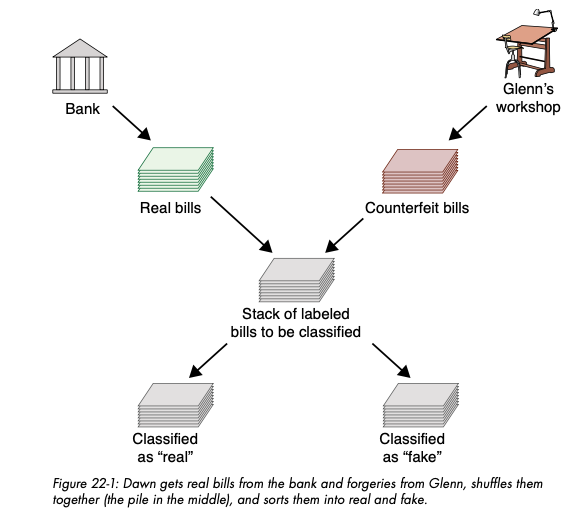

Imagine that there are two protagonists in our story -- **G**lenn, who wants to forge money, and **D**awn, whose job at a bank is to distinguish between the real and fake bills. Glen is a generator and Dawn has a role of a discriminator. At first, Glen does not really know how to make realistic bills, so  Dawn, who has a better idea of what a real bill looks like, does not have too much trouble distinguishing between the fake and the real. However, as time passes, Glen gets better at generating the bills that look like the real ones which were seen by Dawn. So Dawn, too, must  get better at identifying the real and fake bills. As a result, *both* use each other to get better at their respective tasks: Glenn at producing fake but real-looking bills and Dawn at determining which bill is real and which is fake. (This example was taken from Glassner's (2021) textbook on deep learning).

The aim of a **generator** is to convert random noise vector to examples that look like they belong to the training dataset. Note that the generator never sees the training data.

A **discriminator**, on the other hand, is a classifier that aims to correctly predict whether the example (i.e., an input) it received comes from the training data (i.e., is real) or not (i.e, is fake). This is a type of model which we built in weeks 1 and 2, which was trained to solve a multi-class classification problem. In this lab, we will build a binary classifier.

If the discriminator is 100% sure that the fake input is real, then the generator does not improve. However, if the discriminator does "catch" the forgery with an output of less than 1.0, the generator tries to learn from the error by changing how it generates images (i.e. updates the model weights). This feedback loop is key to generating real-looking outputs with GANs.

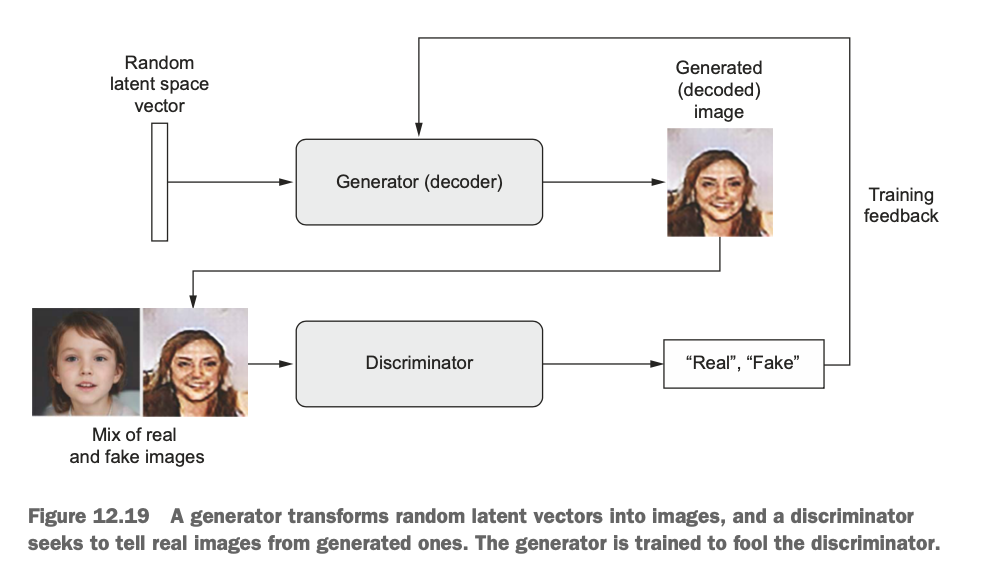

## Importing and preparing data

We will be working with the CelebA dataset which:
- contains over 202,599 face images from 10,177 celebrities;
- images are RGB of size 178x218;

You can learn about the dataset here: http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

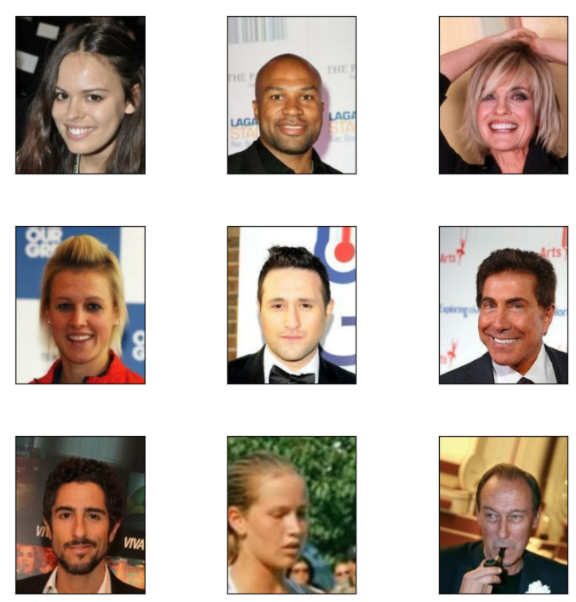

It is not as straightforward to import this dataset as the ones we worked with before, such as MNIST or fashion-MNIST. We will have to downalad the dataset and then upload it to Google Colab, so it appears in the 'Files' tab.

Also, the code for building a GAN was adapted from Chollet's (2021) textbook. Note that since then `Keras` has been updated, so if you copy and paste the code from the textbook, you will get some errors. Given this, it is a great resource to refer to if you're unsure about some aspects of the code.

### Importing Data: Method 1 (preferred)

In [ ]:
# Method 1: download the data from Greta's GDrive and upload it to your Google
# Colab. Note that this is file will not be stored permanently. You will have
# to repeat this step every time if you close this notebook.

!pip install gdown


import gdown

file_id = "1eDj5VZME4yFFLH_EAp7B2LCNmU-tKDYK"
output_file = "img_align_celeba_students.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)

!unzip -qq /content/img_align_celeba_students.zip -d celeba_gan_students

Downloading...
From (original): https://drive.google.com/uc?id=1eDj5VZME4yFFLH_EAp7B2LCNmU-tKDYK
From (redirected): https://drive.google.com/uc?id=1eDj5VZME4yFFLH_EAp7B2LCNmU-tKDYK&confirm=t&uuid=eb4c992e-7c76-4932-a6ab-0bacfb2fdace
To: /content/img_align_celeba_students.zip
100%|██████████| 1.50G/1.50G [00:11<00:00, 131MB/s]


### Importing Data: Method 2

If the Method 1 does not work, then try Method 2. For this, follow the instructions provided in the pdf document to learn how to upload the dataset to the Google Colab: https://livewarwickac-my.sharepoint.com/:b:/g/personal/u1728702_live_warwick_ac_uk/EdhMXVL-IENGrIyfiUF88gABinBjoWGaqLtOFjNp9Af7Iw?e=CVe2ML


In [ ]:
### Method 2: download the data

# !mkdir celeba_gan_students

# !gdown --id 1SJHGSz3A2i8lJk9w6r8H9-mb0-YwtGYv -O celeba_gan_students/data.zip

# If the code above doesn't work, then download from here
# https://drive.google.com/file/d/1SJHGSz3A2i8lJk9w6r8H9-mb0-YwtGYv/view?usp=sharing

In [ ]:
### Method 2
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
### Method 2
#!unzip -qq /content/drive/MyDrive/IM954-files/img_align_celeba.zip -d celeba_gan_students

### Data preparation

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt
import numpy as np


celebs = keras.utils.image_dataset_from_directory("/content/celeba_gan_students/img_align_celeba",
                                                   label_mode=None,
                                                   image_size=(64, 64), # downscale images for faster processing
                                                   batch_size=32, # batch images
                                                   crop_to_aspect_ratio=True) # argument for resizing original images

celebs = celebs.map(lambda x: tf.cast(x, tf.float32) / 255.)


Found 202599 files.


In [ ]:
# Create a subset that contains one batch of images (32 images)
celebs_subset = celebs.take(1)

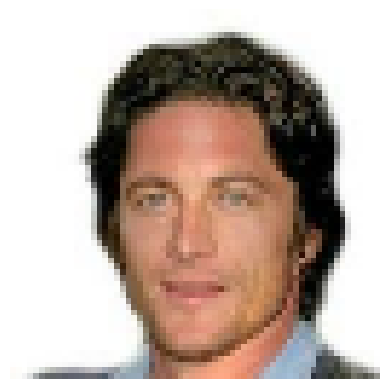

In [ ]:
# visualise an image in the subset data
for x in celebs_subset:
  plt.axis("off")
  plt.imshow((x.numpy() * 255).astype("int32")[4])
  break

In case you wonder why a different image is displayed every time you run the code cell above even though you do not make any changes... shouldn't the same image be displayed? Here's an answer:

> Intuitively, my reply would be yes, but it's not a case. Why? This is related to the fact that the data is shuffled when we read it in. Shuffling (the process of randomising the order in which the data is presented) is a default argument, so it's kind of hidden unless explicitly stated otherwise in the function. If you set the shuffle argument to False then the same image(s) will be displayed, as one would expect.

> Here's the Colab notebook in which you can find how to set shuffling to False and the effect it has on image display: https://colab.research.google.com/drive/1f3BjUy11Khn2VPTfCwE2uJN-eFTg3puj?usp=sharing








## Discriminator

As mentioned, the task of a discriminator is to learn to determine between real (labelled as 1) and fake images (labelled as 0). It aims to *maximise* the probability of making a correct guess so that it is never 'fooled' by the generator.

Our discriminator will be a convolutional neural network, which was introduced in WK2. A [convolutional layer](https://keras.io/api/layers/convolution_layers/convolution2d/) has a number of parameters that can be changed, but we will focus on these:
- number of filers
- kernel size
- stride length
- padding

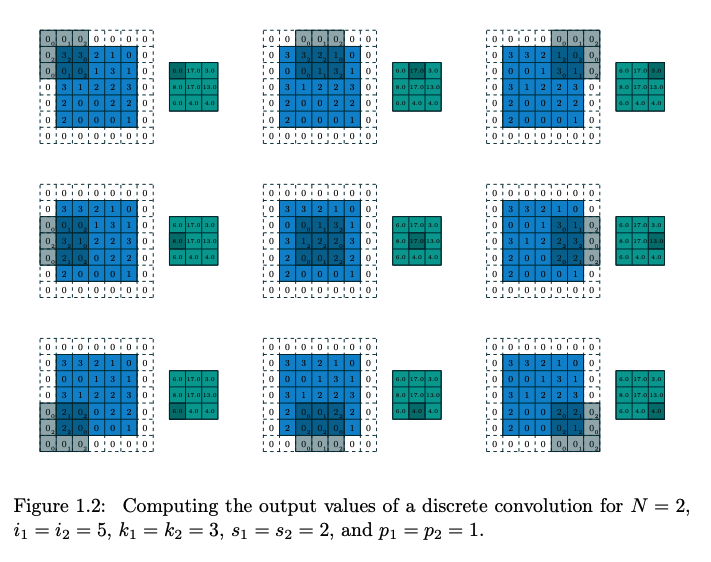
(Dumoulin and Visin 2018 )

#### Architecture

In [ ]:
# the task of the discriminator is to classify an image as real or fake

# define input shape
inputs = keras.Input(shape=(64, 64, 3))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(inputs)
x = layers.LeakyReLU(negative_slope=0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(negative_slope=0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(negative_slope=0.2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

discriminator = models.Model(inputs = inputs,
                             outputs = outputs,
                             name = "discriminator")


In [ ]:
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 404,801 (1.54 MB)

 Trainable params: 404,801 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

## Generator

The task of the generator is to 'fool' the discriminator: it aims to *minimise* the discriminator's probability of making a correct guess. The generator does not 'see' the real data.

#### Conv2DTranspose layer

If the convolutional layer decreases an input size (see the architecture of a discriminator), convolutional transpose layer is used to increase the input size.

Remember, that the output of our generator should be a 3D tensor (i.e. an RGB image) that has the same dimensions as the real images in our training dataset. Hence, generator has to mirror the steps described in the discriminator's architecture.

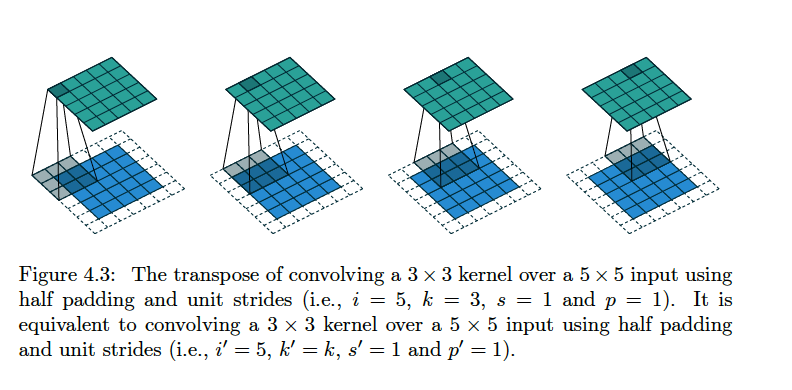

In [ ]:
'''
A minimal example of a convolutional transpose layer.
Here we define and specify values of:
- an input data
- a kernel (2,2)

Then, we will build a minimal Sequential Model with a Conv2DTranspose layer.

Don't forget to change the expected output shape if you change the stride length!
For strides = (2,2), the output shape should beyhat = yhat.reshape((8, 8))
For strides = (1,1), the output shape should beyhat = yhat.reshape((4, 4))
'''

from numpy import asarray
from keras.models import Sequential
from keras.layers import Conv2DTranspose
# define input data
input = asarray([[1, 2, 5,6],
 [3, 4, 6,6],
 [1, 2, 5,6],
 [3, 4, 6,6],])
# show input data for context
print(input)
# reshape input data into one sample a sample with a channel
input = input.reshape((1, 4, 4, 1))
# define model
model = Sequential()
model.add(Conv2DTranspose(1, (2,2),
                          strides=(3,3),
													input_shape=(4, 4, 1)))
# summarize the model
model.summary()
# define weights that they do nothing
weights = [asarray([[[[2]], [[3]]], [[[1]],[[2]]]]), asarray([0])]
print(weights)
# store the weights in the model
model.set_weights(weights)
# make a prediction with the model
yhat = model.predict(input)
# reshape output
yhat = yhat.reshape((12, 12))
# summarize output
print(yhat)


[[1 2 5 6]
 [3 4 6 6]
 [1 2 5 6]
 [3 4 6 6]]


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 12, 12, 1)           │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5 (20.00 B)

 Trainable params: 5 (20.00 B)

 Non-trainable params: 0 (0.00 B)

[array([[[[2]],

        [[3]]],


       [[[1]],

        [[2]]]]), array([0])]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[[ 2.  3.  0.  4.  6.  0. 10. 15.  0. 12. 18.  0.]
 [ 1.  2.  0.  2.  4.  0.  5. 10.  0.  6. 12.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 6.  9.  0.  8. 12.  0. 12. 18.  0. 12. 18.  0.]
 [ 3.  6.  0.  4.  8.  0.  6. 12.  0.  6. 12.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 2.  3.  0.  4.  6.  0. 10. 15.  0. 12. 18.  0.]
 [ 1.  2.  0.  2.  4.  0.  5. 10.  0.  6. 12.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 6.  9.  0.  8. 12.  0. 12. 18.  0. 12. 18.  0.]
 [ 3.  6.  0.  4.  8.  0.  6. 12.  0.  6. 12.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


#### Architecture

In [ ]:
# the generator will take a random noise as input, which will be turned
# into an RDG image

latent_dim = 128 # latent space will be made of 128-dimensional vectors

inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 128)(inputs)
x = layers.Reshape((8, 8, 128))(x)
x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(negative_slope=0.2)(x)
x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(negative_slope=0.2)(x)
x = layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(negative_slope=0.2)(x)
outputs = layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid")(x)

generator = models.Model(inputs = inputs,
                         outputs = outputs,
                         name = "generator")


In [ ]:
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8192)                │       1,056,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 16, 16, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 64, 64, 512)         │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64, 64, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 3)           │          38,403 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

## GAN Model


Our GAN model will do the following:
1. Draw random points from the latent space, resulting in a random noise vector.
2. Generate images with the generator using the random noise from step 1.
3. Mix the generated images with real ones.
4. Train the discriminator using the mixed images from step 3. Each input will be labeled either “real” (for the real images) or “fake” (for the generated images).
5. Draw new random points in the latent space.
6. Train the generator using these random vectors, with targets that all say “these are real images.” This updates the weights of the generator to move them toward getting the discriminator to predict “these are real images” for generated images: this trains the generator to fool the discriminator.

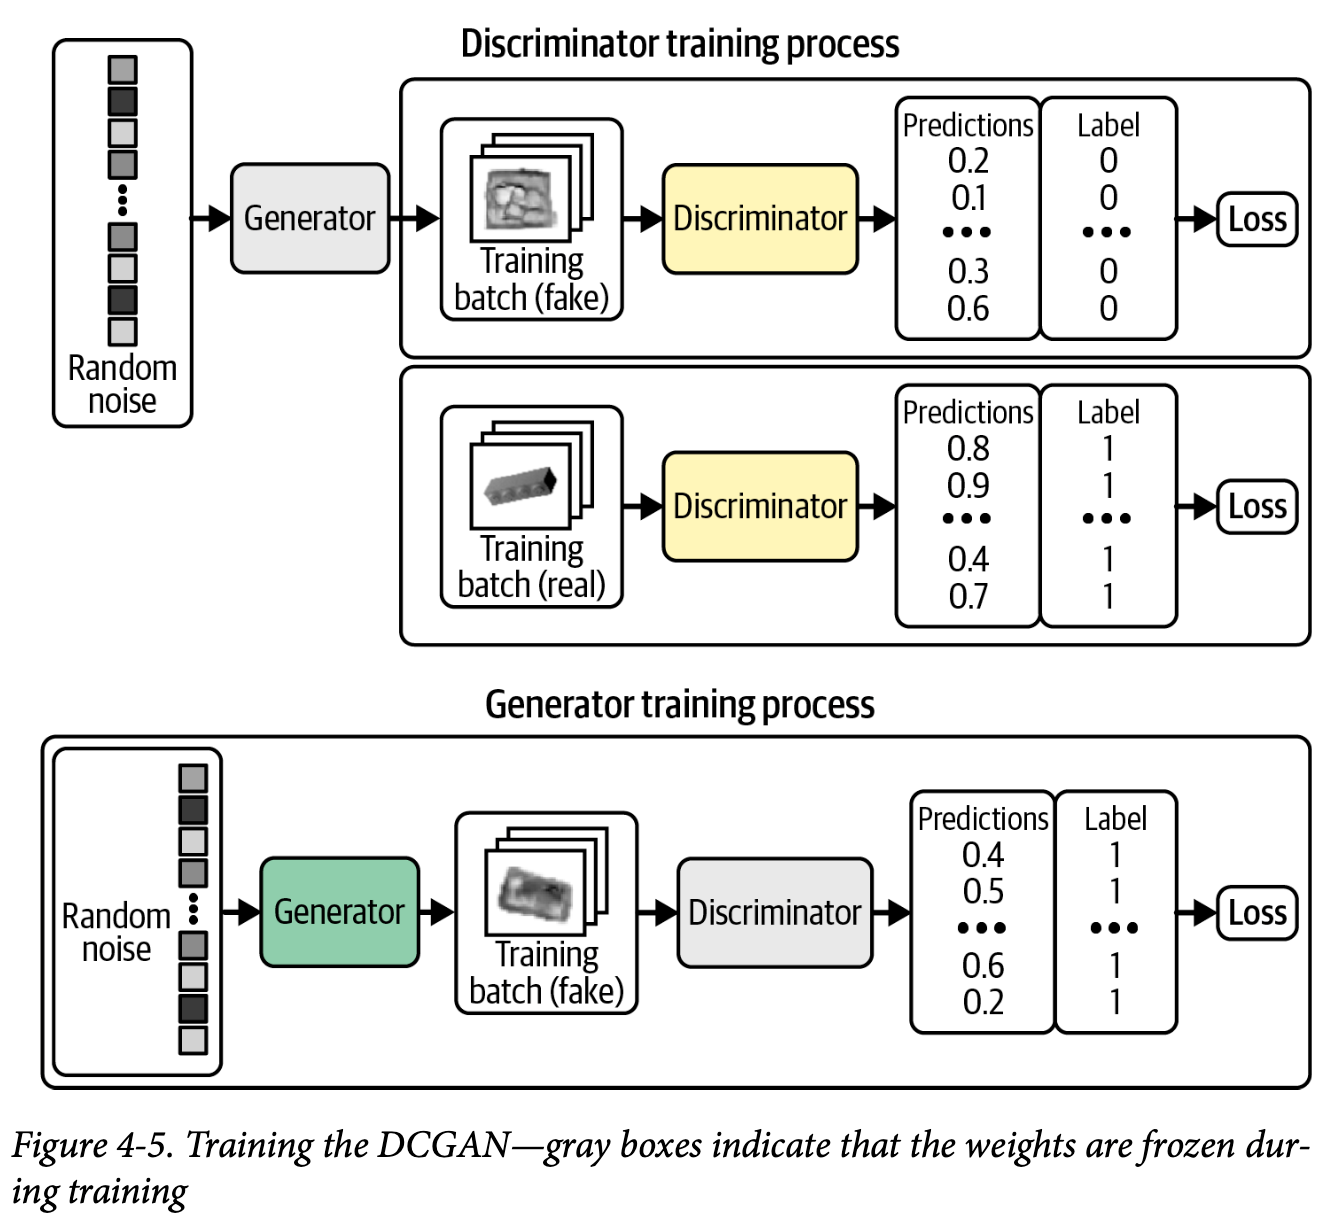

You can think of GAN training as consisting of 4 potential steps (adapted from Glassner 2021):
1. If a discriminator is given a *real* image and classifies it as *true*, nothing happens.
2. If a discriminator is given a *real* image and classifies it as *fake*, then an error/loss function will make the discriminator update its weights. (Figure 22-10)
3. If a discriminator is given a *fake* image and classifies it as *true*, then the discriminator's weights will be updated (Figure 22-12).
4. If a discriminator is given a *fake* image and classifies it as *fake*, then the generator's weights will be updated (Figure 22-11).

Note: in the examples below, we assume that weights are updated after every image. But in reality (and in the model we will build), the weights will be updated after every batch by taking an average.

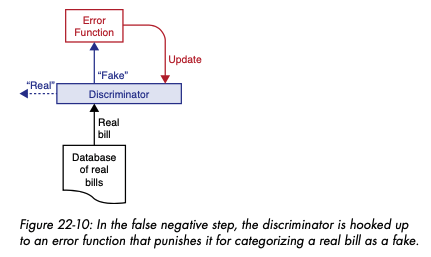

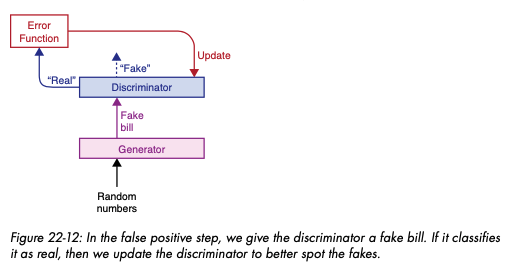



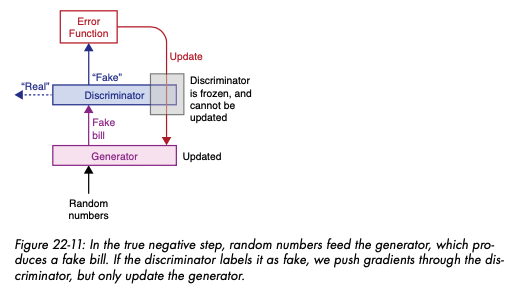

In [ ]:
class GAN(keras.Model):
  # sets up metrics to track the two losses over each training epoch
  def __init__(self, discriminator, generator, latent_dim):
    super().__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim
    self.d_loss_metric = keras.metrics.Mean(name = "d_loss")
    self.g_loss_metric = keras.metrics.Mean(name = "g_loss")

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn

  @property
  def metrics(self):
    return [self.d_loss_metric, self.g_loss_metric]

  def train_step(self, real_images):
    batch_size = tf.shape(real_images)[0]
    # random point sampling
    random_latent_vectors = tf.random.normal(
        shape=(batch_size, self.latent_dim))
    # decodes the random noise to fake images
    generated_images = self.generator(random_latent_vectors)
    # combines the fake images with the real ones
    combined_images = tf.concat([generated_images, real_images], axis = 0)
    # assembles labels, discriminating between real and fake images
    labels = tf.concat( [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0 )
    # adds noise to the labels
    labels += 0.05 * tf.random.uniform(tf.shape(labels))

    # training the discriminator
    with tf.GradientTape() as tape:
      predictions = self.discriminator(combined_images)
      d_loss = self.loss_fn(labels, predictions)
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(
        zip(grads, self.discriminator.trainable_weights)
    )

    # random point sampling in the latent space
    random_latent_vectors = tf.random.normal(
        shape = (batch_size, self.latent_dim))
    # assembles labels that are real
    misleading_labels = tf.zeros((batch_size, 1))

    # training the generator
    with tf.GradientTape() as tape: ### import gradienttape
      predictions = self.discriminator(
          self.generator(random_latent_vectors))
      g_loss = self.loss_fn(misleading_labels, predictions)
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(
        zip(grads, self.generator.trainable_weights))

    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)
    return{"d_loss": self.d_loss_metric.result(),
           "g_loss": self.g_loss_metric.result()}



In [ ]:
# the code below will help us to monitor the results of a GAN model by creating
# and saving fake images

class GANMonitor(keras.callbacks.Callback):
  def __init__(self, num_img=3, latent_dim = latent_dim):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs = None):
    random_latent_vectors = tf.random.normal(
        shape = (self.num_img, self.latent_dim))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()

    for i in range(self.num_img):
      img = keras.utils.array_to_img(generated_images[i])
      img.save(f"generated_img{epoch:03d}_{i}.png")

### Train the model

In [ ]:
epochs = 100
gan = GAN(discriminator = discriminator,
          generator = generator,
          latent_dim = latent_dim)

gan.compile(
    d_optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
    g_optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
    loss_fn = keras.losses.BinaryCrossentropy()
)

gan.fit(celebs,
        epochs = epochs,
        callbacks = [GANMonitor(num_img = 1,
                                latent_dim = latent_dim)])


   4/6332 ━━━━━━━━━━━━━━━━━━━━ 10:46:15 6s/step - d_loss: 0.6834 - g_loss: 0.7711

KeyboardInterrupt: 

If you save a sample of a generated image after an epoch of training, you can see how the model learns to generate images that increasingly look like real.

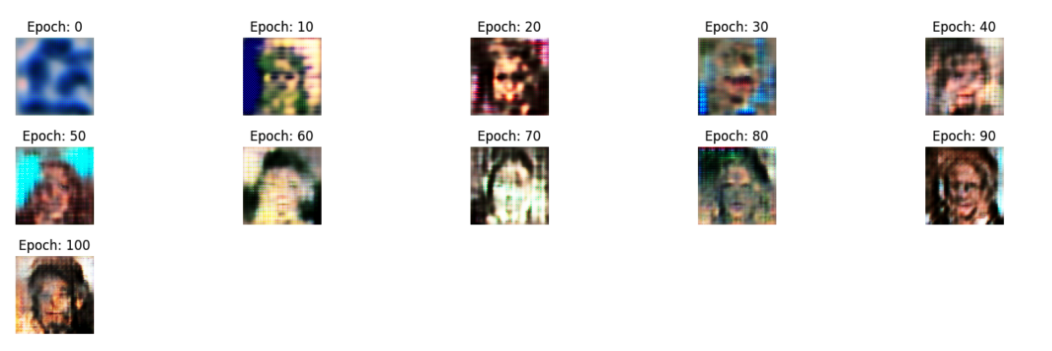

In [ ]:
# Below is the code for displaying images from the directory in a grid
# (as in the image above)

'''
# Python code to list the directory.
import os
pictures = os.listdir("/link-to-your-folder-with-images") #change it to your folder with images!
pictures.sort()
print(pictures)

img0 = plt.imread(pictures[0])
img1 = plt.imread(pictures[1])
img2 = plt.imread(pictures[2])
img3 = plt.imread(pictures[3])
img4 = plt.imread(pictures[4])
img5 = plt.imread(pictures[5])
img6 = plt.imread(pictures[6])
img7 = plt.imread(pictures[7])
img8 = plt.imread(pictures[8])
img9 = plt.imread(pictures[9])
img10 = plt.imread(pictures[10])

images = [img0, img1, img2, img3, img4, img5, img6, img7, img8, img9, img10]

grid_width, grid_height = (5, 3)

# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(11):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(images[i])
    ax.set_title(f"Epoch: {i*10}")

'''

## Generate new images

In [ ]:
import numpy as np
grid_width, grid_height = (5, 3) # this will, basically, determine the number of
# generated new images; in this case it will be 15 new images
# (3 rows and 5 columns)

latent_dim = 128

# generating random vectors as an input to a generator
z_sample = np.random.normal(size=(grid_width * grid_height, latent_dim))

# Decode the sampled points
reconstructions = generator.predict(z_sample)

# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

### Save the model

In [ ]:
# Save the trained generator and discriminator for future use.
# Note, you only need a generator for new image generation.

#generator.save("./generator.keras")
#discriminator.save("./discriminator.keras")

## Loading up pre-trained GAN

In this section, you will download and load up a generator trained on 100 epochs. Then, you will use the generator to visualise new images.

In [ ]:
# Load up the GAN

import gdown

file_id = "1QpOjLhuUe4KObxGm_PTtELYoJz4S6CvZ"
output_file = "generator.keras"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)

Downloading...
From: https://drive.google.com/uc?id=1QpOjLhuUe4KObxGm_PTtELYoJz4S6CvZ
To: /content/generator.keras
100%|██████████| 16.0M/16.0M [00:00<00:00, 84.0MB/s]


'generator.keras'

In [ ]:
import tensorflow as tf

generator_pt = tf.keras.models.load_model('generator.keras')

# Show the model architecture
generator_pt.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8192)                │       1,056,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 16, 16, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 64, 64, 512)         │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 64, 64, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 3)           │          38,403 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,979,651 (15.18 MB)

 Trainable params: 3,979,651 (15.18 MB)

 Non-trainable params: 0 (0.00 B)

### Image generation

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


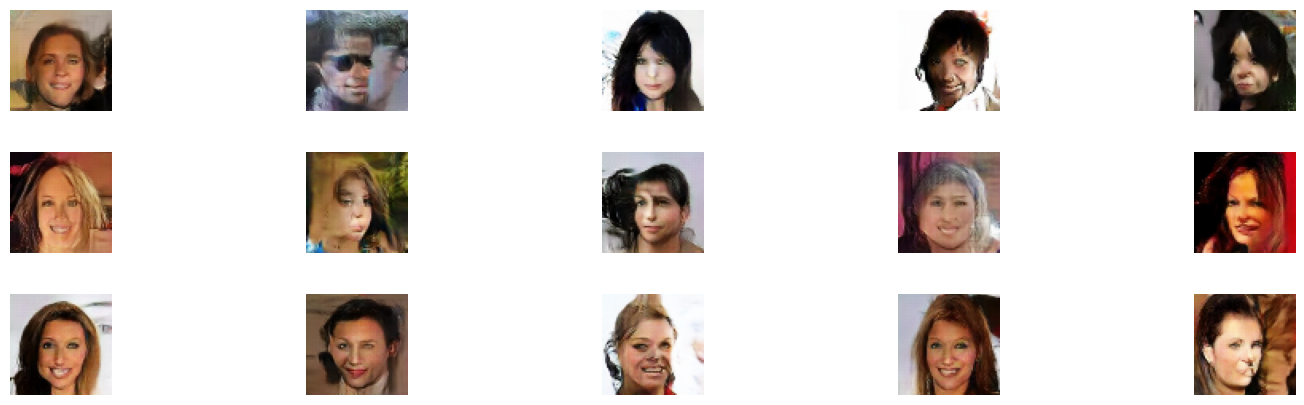

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

grid_width, grid_height = (5, 3) # this will, basically, determine the number of
# generated new images; in this case it will be 15 new images
# (3 rows and 5 columns)

latent_dim = 128

# generating random vectors as an input to a generator
z_sample = np.random.normal(size=(grid_width * grid_height, latent_dim))

# Decode the sampled points
reconstructions = generator_pt.predict(z_sample)

# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

### Define your own vector noise!

We do not need to use random number generator to generate new images. We can define our own noise vector. In the example below we will manually initialise the first three elements in a vector, so that these values are either less or more activated. In this case, we can try to understand how each element in a vector might contribute to the generated image.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

grid_width, grid_height = (1, 2) # this will, basically, determine the number of
# generated new images; in this case it will be 15 new images
# (3 rows and 5 columns)

# First, let's reduce our latent_dim, which will be populated with random numbers
# We will append the 125-element vector with manually defined values
latent_dim = 125

# Generate random vectors as an input 1 to a generator
# Then we will add three elements of value 0.1 (this can be changed)
z_sample = np.random.normal(size=(1 * 1, latent_dim))
#print(z_sample)
z_sample0 = np.append(0.01, z_sample)
print(z_sample0)
z_sample0_end = np.append(z_sample, 0.01)
print(z_sample0_end)
z_sample0 = np.append(0.01, z_sample0)
z_sample0 = np.append(0.01, z_sample0)
z_sample0 = z_sample0.reshape(1, 128)
z_sample0 = tf.convert_to_tensor(z_sample0)

# Let's define a second vector
# but let's use higher values
z_sample1 = np.append(0.99, z_sample)
z_sample1 = np.append(0.99, z_sample1)
z_sample1 = np.append(0.99, z_sample1)
z_sample1 = z_sample1.reshape(1, 128)
z_sample1 = tf.convert_to_tensor(z_sample1)


[ 0.01        0.2672927  -0.31807811 -0.98776     0.25954124 -0.48669054
 -0.19800674 -0.01392423 -0.3966928   1.66946575  1.05202643  0.99308282
 -0.63006891  0.92206157 -0.5141992  -1.67948239  0.05531889  1.17005041
  0.06049857 -0.30391613  1.03483561  0.97796652 -0.81019597  0.67522677
  0.65743839  0.79248876 -1.705926   -2.67293169  0.71131119 -0.89547844
  0.13583967  1.59664398 -1.15087779 -0.16726361 -1.63911276  1.69300666
  0.14913075 -0.79490857 -0.03562277 -0.05322438 -1.20182617  0.51896677
  1.54032317  1.1834972  -0.48813443  1.36984956  0.98100024  0.25782215
  1.50789708  0.97842848  1.62068623  1.39031681 -0.93986267 -0.53312571
  0.02948036 -0.45740738  1.24052015  0.64236449  0.36506802 -0.91383381
  0.33892052 -0.63231628 -0.04115647 -0.8369508  -0.4883199  -1.04373677
 -0.21132717  1.47769407  0.60521895  1.42648722  0.51186422 -2.04712353
 -0.62807871  0.98879517  0.41824015 -0.72832682 -0.04734177 -0.09487843
  0.1636731  -0.61932127  0.35294237  2.6853044  -1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


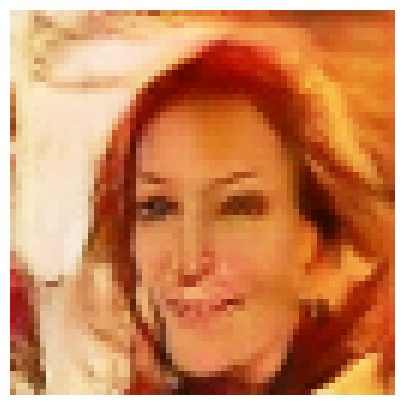

In [ ]:
# Decode the sampled points for z_sample0
reconstructions0 = generator_pt.predict(z_sample0)

# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(1 * 1):
    ax = fig.add_subplot(1, 1, 1)
    ax.axis("off")
    ax.imshow(reconstructions0[i, :, :], cmap="Greys")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


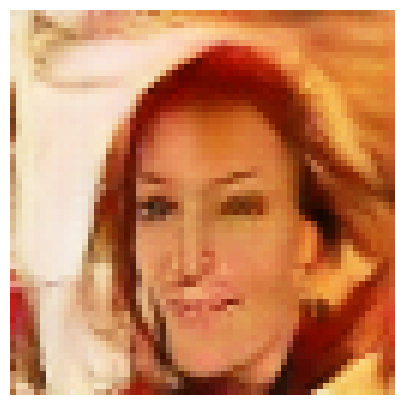

In [ ]:
# Decode the sampled points z_sample1
reconstructions1 = generator_pt.predict(z_sample1)

# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(1 * 1):
    ax = fig.add_subplot(1, 1, 1)
    ax.axis("off")
    ax.imshow(reconstructions1[i, :, :], cmap="Greys")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


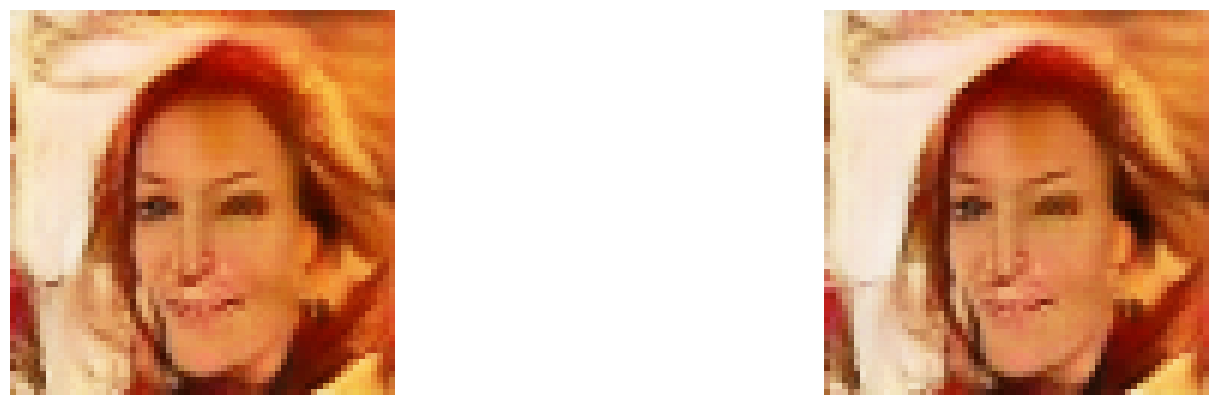

In [ ]:
z_sample_concat= tf.concat([z_sample0, z_sample1], 0)

# Decode the sampled points
reconstructions_concat = generator_pt.predict(z_sample_concat)

# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

grid_height = 1
grid_width = 2

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions_concat[i, :, :], cmap="Greys")



## Tips and Tricks


You can find various tips and tricks for training GANs. In this section, I want to draw your attention to two potential problems: 'mode collapse' and 'checkerboard artifacts'.



### Mode collapse

Mode collapse happens when a generator overpowers the discriminator. It means that the generator found a way (a mode) to 'fool' the discriminator by always generating the same image which was classified as 'true'. This happens despite different noise vectors being initialised every time to generate an image. If this happens, the generator stops learning (i.e. updating its weight parameters).

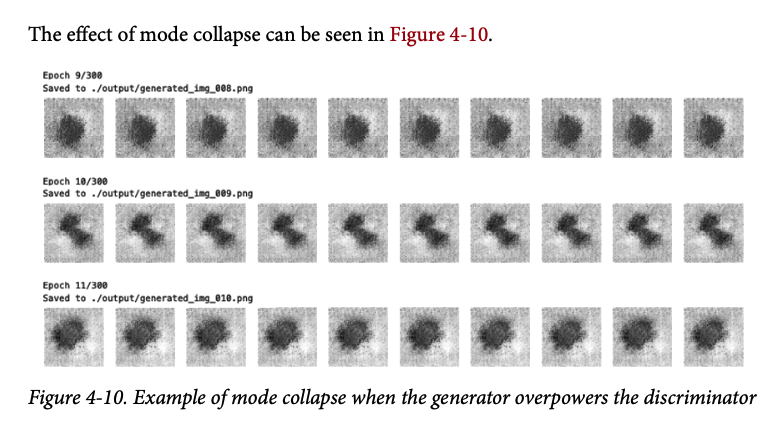

### Checkerboard artifacts

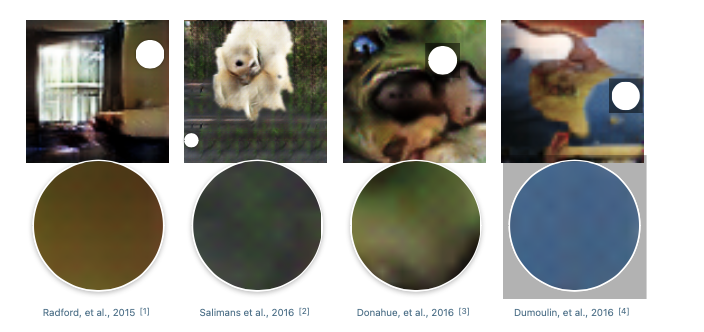

The so-called 'checkerboard artifacts' have been observed in the generated images. This happens because of the overlaps that might happen in the Conv2DTranspose layer when our stride length (e.g. 2) is smaller than kernel size (e.g. 3x3). So, a way to avoid this is to make sure that our stride length is equal or larger than the kernel size.

❓ In the model we built in this lab, is stride length lower than kernel size? Did we avoid the checkerboard pattern? Why?

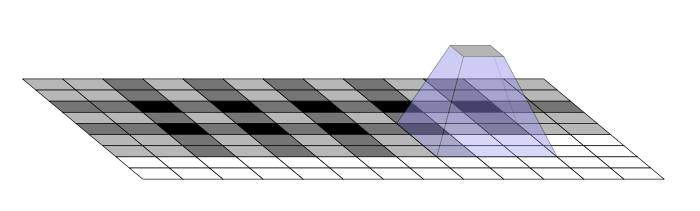

# Resources

**Recommended resources:**
- Chollet, F. (2021) Deep Learning with Python. 2nd edn. Manning.
  - Chapter 12 (pp.401-411)
- Foster, D. (2023) Generative Deep Learning: Teaching Machines to Paint, Write, Compose, and Play. 2nd edition. Beijing Boston Farnham Sebastopol Tokyo: Oreilly & Associates Inc.
  - Chapters 3 (pp.59-74) and 4 (pp.95-113)


**Suggested**:
- Dumoulin, Vincent, and Francesco Visin. 2018. “A Guide to Convolution Arithmetic for Deep Learning.” arXiv. https://doi.org/10.48550/arXiv.1603.07285.
- Goodfellow, Ian J., Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, and Yoshua Bengio. 2014. “Generative Adversarial Networks.” arXiv. https://doi.org/10.48550/arXiv.1406.2661.
- Goodfellow, Ian. 2017. “NIPS 2016 Tutorial: Generative Adversarial Networks.” arXiv. https://doi.org/10.48550/arXiv.1701.00160.
- Glassner, A. (2021) Deep Learning: A Visual Approach. Illustrated edition. San Francisco: No Starch Press.
  - Chapter 22 (pp.650-673); Python scripts are available on Github
- Odena, Augustus, Vincent Dumoulin, and Chris Olah. 2016. “Deconvolution and Checkerboard Artifacts.” Distill 1 (10): e3. https://doi.org/10.23915/distill.00003.
- Radford, Alec, Luke Metz, and Soumith Chintala. 2016. “Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks.” arXiv. https://doi.org/10.48550/arXiv.1511.06434.


**Other Tutorials and GAN Architecture Extensions:**
- DCGAN tutorial on Tensorflow: https://www.tensorflow.org/tutorials/generative/dcgan
- Check out the GAN Zoo to learn about various GAN implementations: https://github.com/hindupuravinash/the-gan-zoo
- Conditional GANs:  
  - Foster, D. (2023) Generative Deep Learning: Teaching Machines to Paint, Write, Compose, and Play. 2nd edition. Beijing Boston Farnham Sebastopol Tokyo: Oreilly & Associates Inc.
    - pp.122-127

**Convolutional Transpose Layer:**
- Brownlee, Jason. 2019. “How to Use the UpSampling2D and Conv2DTranspose Layers in Keras.” MachineLearningMastery.Com (blog). June 23, 2019. https://www.machinelearningmastery.com/upsampling-and-transpose-convolution-layers-for-generative-adversarial-networks/
- https://www.geeksforgeeks.org/what-is-transposed-convolutional-layer/
